In [34]:
import pandas as pd
import numpy as np

In [35]:
ben_df_folder = "/kaggle/input/modified-hate-speech-bengali-hindi/bengali-hate-speech/"
ben_df_dict = {}
ben_df_dict['train'] = pd.read_csv(ben_df_folder + "bengali-hate-speech_train.csv")
ben_df_dict['test'] = pd.read_csv(ben_df_folder + "bengali-hate-speech_test.csv")
ben_df_dict['valid'] = pd.read_csv(ben_df_folder + "bengali-hate-speech_valid.csv")

In [36]:
hin_df_folder = "/kaggle/input/modified-hate-speech-bengali-hindi/hindi-hate-speech/"
hin_df_dict = {}
hin_df_dict['train'] = pd.read_csv(hin_df_folder + "hindi-hate-speech_train.csv")
hin_df_dict['test'] = pd.read_csv(hin_df_folder + "hindi-hate-speech_test.csv")
hin_df_dict['valid'] = pd.read_csv(hin_df_folder + "hindi-hate-speech_valid.csv")

In [37]:
merged_df_dict = {}
for key in ben_df_dict.keys():
    merged_df_dict[key] = pd.concat([ben_df_dict[key], hin_df_dict[key]], axis=0, ignore_index=True)

In [38]:
from datasets import Dataset, DatasetDict

In [39]:
merged_dataset_dict = DatasetDict()
for key in merged_df_dict.keys():
    merged_dataset_dict[key] = Dataset.from_pandas(merged_df_dict[key])

In [40]:
features = merged_dataset_dict['train'].column_names
features.remove('text')
num_features = len(features)
features, num_features

(['defamation', 'hate', 'non-hate', 'violence', 'vulgar'], 5)

In [41]:
import tensorflow as tf
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification

In [62]:
model_name = "distilbert/distilbert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    problem_type="multi_label_classification",
    num_labels=num_features
)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [43]:
def tokenize_dataset(dataset):
    encoding = tokenizer(
        dataset['text'],
        padding="max_length",
        max_length=256,
        truncation=True
    )
    labels_batch = {k: dataset[k] for k in dataset.keys() if k in features}
    labels_matrix = np.zeros((len(dataset['text'],), len(features)))
    for idx, label in enumerate(features):
        labels_matrix[:, idx] = labels_batch[label]
    encoding['labels'] = labels_matrix.tolist()
    return encoding

encoded_dataset_dict_tokenized = merged_dataset_dict.map(
    tokenize_dataset,
    batched=True,
    remove_columns=['text'] + features
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/16979 [00:00<?, ? examples/s]

Map:   0%|          | 0/4868 [00:00<?, ? examples/s]

Map:   0%|          | 0/2418 [00:00<?, ? examples/s]

In [44]:
encoded_dataset_dict_tokenized.set_format(
    type='torch'
)

In [45]:
encoded_dataset_dict_tokenized

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 16979
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 4868
    })
    valid: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2418
    })
})

In [46]:
import sklearn.metrics as matrices
from transformers import EvalPrediction

In [47]:
args = TrainingArguments(
    output_dir='./results/',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=3,
    learning_rate=1e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
)

In [48]:
# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    probs = tf.math.sigmoid(predictions)
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = matrices.f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = matrices.roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = matrices.accuracy_score(y_true, y_pred)
    hamming_loss = matrices.hamming_loss(y_true, y_pred)
    jaccard_score = matrices.jaccard_score(y_true, y_pred, average='micro')
    zero_one_loss = matrices.zero_one_loss(y_true, y_pred)
    # return as dictionary
    metrics = {
        'f1': f1_micro_average,
        'roc_auc': roc_auc,
        'accuracy': accuracy,
        'hamming_loss': hamming_loss,
        'jaccard_score': jaccard_score,
        'zero_one_loss': zero_one_loss
    }
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds, 
        labels=p.label_ids)
    return result

In [49]:
from transformers import TrainingArguments, Trainer

In [68]:
args = TrainingArguments(
    output_dir='./results/',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=3,
    learning_rate=1e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
)

In [69]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset_dict_tokenized['train'],
    eval_dataset=encoded_dataset_dict_tokenized['valid'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [71]:
trainer.train(resume_from_checkpoint=True)

Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy,Hamming Loss,Jaccard Score,Zero One Loss,Runtime,Samples Per Second,Steps Per Second
6,0.192900,0.224933,0.776508,0.849246,0.695203,0.092225,0.634666,0.304797,10.210000,236.827000,7.444000
7,0.186700,0.221450,0.781870,0.850494,0.704715,0.089165,0.641860,0.295285,10.230300,236.356000,7.429000
8,0.178900,0.221760,0.783621,0.853296,0.704301,0.089165,0.644224,0.295699,10.212000,236.780000,7.442000
9,0.171500,0.222711,0.782036,0.853539,0.704715,0.090323,0.642085,0.295285,10.201000,237.035000,7.450000
10,0.163400,0.220924,0.784016,0.854539,0.704715,0.089413,0.644758,0.295285,10.188100,237.336000,7.460000


TrainOutput(global_step=5310, training_loss=0.08795196691250846, metrics={'train_runtime': 1125.133, 'train_samples_per_second': 150.907, 'train_steps_per_second': 4.719, 'total_flos': 1.127185656986112e+16, 'train_loss': 0.08795196691250846, 'epoch': 10.0})

In [77]:
trainer.evaluate()

{'eval_loss': 0.2209239900112152,
 'eval_f1': 0.784015984015984,
 'eval_roc_auc': 0.8545388830682432,
 'eval_accuracy': 0.7047146401985112,
 'eval_hamming_loss': 0.08941273779983458,
 'eval_jaccard_score': 0.6447584620440355,
 'eval_zero_one_loss': 0.29528535980148884,
 'eval_runtime': 10.2263,
 'eval_samples_per_second': 236.449,
 'eval_steps_per_second': 7.432,
 'epoch': 10.0}

In [78]:
actual_labels = encoded_dataset_dict_tokenized['test']['labels']
pred_labels = trainer.predict(
    encoded_dataset_dict_tokenized['test']
)

In [79]:
probs = tf.math.sigmoid(pred_labels.predictions)
y_pred = np.zeros(probs.shape)
y_pred[np.where(probs >= 0.3)] = 1

In [80]:
print('Accuracy Score: ', matrices.accuracy_score(actual_labels, y_pred))
print('F1 Score: ', matrices.f1_score(actual_labels, y_pred, average='micro'))
print('ROC AUC: ', matrices.roc_auc_score(actual_labels, y_pred, average='micro'))
print('Hamming Loss: ', matrices.hamming_loss(actual_labels, y_pred))
print('Jaccard Score: ', matrices.jaccard_score(actual_labels, y_pred, average='micro'))
print('Zero-One Loss:', matrices.zero_one_loss(actual_labels, y_pred))

print('\nClassification Report :-\n',
      matrices.classification_report(
          actual_labels,
          y_pred,
          output_dict=False,
          target_names=features,
      )
     )

Accuracy Score:  0.6727608874281019
F1 Score:  0.7774395702775291
ROC AUC:  0.8734054450662194
Hamming Loss:  0.10213640098603123
Jaccard Score:  0.6359109548916227
Zero-One Loss: 0.3272391125718981

Classification Report :-
               precision    recall  f1-score   support

  defamation       0.57      0.77      0.65       997
        hate       0.52      0.64      0.57       598
    non-hate       0.93      0.93      0.93      2421
    violence       0.65      0.77      0.70       482
      vulgar       0.67      0.78      0.72       730

   micro avg       0.73      0.83      0.78      5228
   macro avg       0.67      0.78      0.72      5228
weighted avg       0.75      0.83      0.79      5228
 samples avg       0.73      0.79      0.74      5228



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [81]:
import matplotlib.pyplot as plt

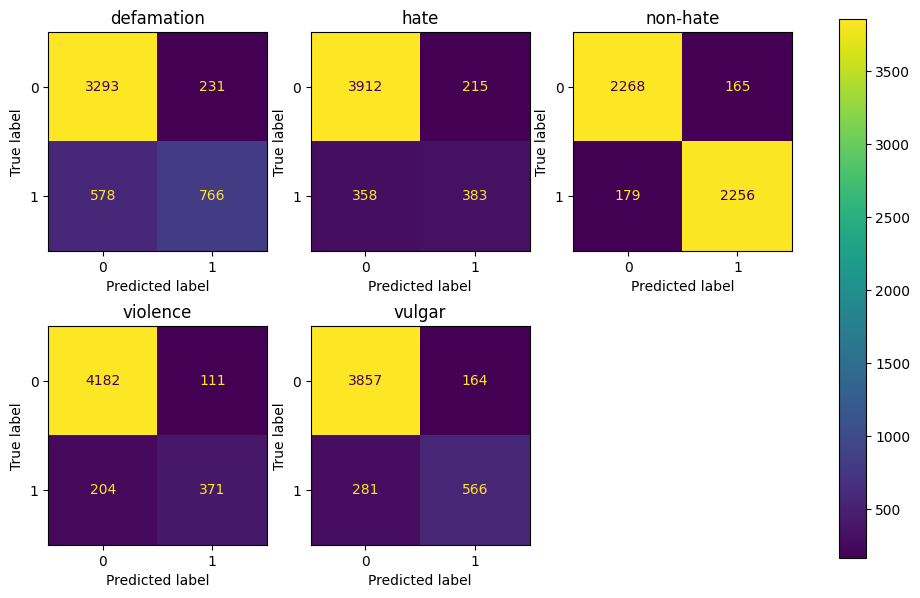

In [82]:
confusion_matrices =  matrices.multilabel_confusion_matrix(
    y_pred,
    actual_labels
)

fig, axis = plt.subplots(2, 3, figsize=(12, 7))
axis = axis.ravel()
for i in range(len(confusion_matrices)):
    disp = matrices.ConfusionMatrixDisplay(
        confusion_matrices[i],
    )
    disp.plot(ax=axis[i], values_format='.4g')
    disp.ax_.set_title(features[i])
    disp.im_.colorbar.remove()
fig.colorbar(disp.im_, ax=axis)
axis[5].remove()

In [83]:
import os

In [84]:
trained_model_name = model_name.split('/')[1] + '-hate-speech-ben-hin-epochs-' + str(args.num_train_epochs)
trainer.save_model('./' + trained_model_name)

In [85]:
os.system("cd /kaggle/working/; zip -r "+trained_model_name+".zip ./"+trained_model_name)

  adding: distilbert-base-multilingual-cased-hate-speech-ben-hin-epochs-10/ (stored 0%)
  adding: distilbert-base-multilingual-cased-hate-speech-ben-hin-epochs-10/vocab.txt (deflated 45%)
  adding: distilbert-base-multilingual-cased-hate-speech-ben-hin-epochs-10/model.safetensors (deflated 7%)
  adding: distilbert-base-multilingual-cased-hate-speech-ben-hin-epochs-10/tokenizer.json (deflated 67%)
  adding: distilbert-base-multilingual-cased-hate-speech-ben-hin-epochs-10/config.json (deflated 51%)
  adding: distilbert-base-multilingual-cased-hate-speech-ben-hin-epochs-10/tokenizer_config.json (deflated 75%)
  adding: distilbert-base-multilingual-cased-hate-speech-ben-hin-epochs-10/special_tokens_map.json (deflated 42%)
  adding: distilbert-base-multilingual-cased-hate-speech-ben-hin-epochs-10/training_args.bin (deflated 51%)


0